In [1]:
import sys
sys.path.insert(0,'chess-alpha-zero')
sys.path.insert(0,'chess-alpha-zero/src')

from src.chess_zero.manager import *
from src.chess_zero.worker.evaluate import *
from src.chess_zero.env.chess_env import canon_input_planes, maybe_flip_fen, is_black_turn

from collections import namedtuple
import chess.pgn

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--cmd", help="what to do", choices=CMD_LIST, default='eval')
parser.add_argument("--new", help="run from new best model", action="store_true")
parser.add_argument("--type", help="use normal setting", default="mini")
parser.add_argument("--total-step", help="set TrainerConfig.start_total_steps", type=int)
args = parser.parse_args('')

cfg = Config(args.type)
setup(cfg, args)
ev = EvaluateWorker(cfg)
model = ChessModel(cfg)
model.load(
    'data/model/model_best_config.json',
    'data/model/model_best_weight.h5'
)

2021-04-12 04:26:22,203@chess_zero.agent.model_chess DEBUG # loading model from /home/pp456/visualizing-ml/ai/chess-alpha-zero/data/model/model_best_config.json


2021-04-12 04:26:22,206@tensorflow WARNING # From /home/pp456/anaconda3/envs/chess-az/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:442: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



2021-04-12 04:26:22,232@tensorflow WARNING # From /home/pp456/anaconda3/envs/chess-az/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3543: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Instructions for updating:
keep_dims is deprecated, use keepdims instead


2021-04-12 04:26:22,253@tensorflow WARNING # From /home/pp456/anaconda3/envs/chess-az/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1188: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


2021-04-12 04:26:22,323@tensorflow WARNING # From /home/pp456/anaconda3/envs/chess-az/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:112: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



Instructions for updating:
keep_dims is deprecated, use keepdims instead


2021-04-12 04:26:23,643@tensorflow WARNING # From /home/pp456/anaconda3/envs/chess-az/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1205: calling reduce_prod_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


2021-04-12 04:26:23,941@tensorflow WARNING # From /home/pp456/anaconda3/envs/chess-az/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:153: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



2021-04-12 04:26:23,943@tensorflow WARNING # From /home/pp456/anaconda3/envs/chess-az/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:158: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



2021-04-12 04:26:23,945@tensorflow WARNING # From /home/pp456/anaconda3/envs/chess-az/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:163: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



2021-04-12 04:26:24,706@tensorflow WARNING # From /home/pp456/anaconda3/envs/chess-az/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:333: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



2021-04-12 04:26:24,708@tensorflow WARNING # From /home/pp456/anaconda3/envs/chess-az/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:341: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.

2021-04-12 04:26:25,530@chess_zero.agent.model_chess DEBUG # loaded model digest = 259dc1c022276e4d6d2c7faa7b037a20ccac4b4a039cce14548ed47b45894b78
2021-04-12 04:26:25,610@chess_zero.agent.model_chess DEBUG # model files does not exist at data/model/model_best_config.json and data/model/model_best_weight.h5


False

In [3]:
# helper functions

def reverse_move(move):
    # ugly as hell
    rev_alpha = {'a':'h','b':'g','c':'f','d':'e','e':'d','f':'c','g':'b','h':'a'}
    return rev_alpha[move[0]] + str(9-int(move[1])) + rev_alpha[move[2]] + str(9-int(move[3]))

def fen_to_onehot_grid(fen, white=True):
    fen = fen.split(' ')[0].split('/') # trim metadata, split into rows
    grid = np.zeros([8,8])
    for row_idx, row in enumerate(fen):
        col_idx = 0
        for c in row:
            if c.isnumeric(): # space: increment
                for i in range(int(c)): col_idx += 1
            else: # character
                if white and c.isupper():
                    grid[row_idx][col_idx] = 1
                if not white and c.islower():
                    grid[row_idx][col_idx] = 1
                col_idx += 1
    return grid

class ChessTreeNode:
    
    def __init__(self, fen):
        self.fen = fen
        self.children = {}
        
    def viz(self):
        chess.Board(self.fen)
        
    def pprint(self, level=0, transition_move=''):
        ret = "\t"*level+repr(transition_move)+"\n"
        for move, (node, move_p) in self.children.items():
            ret += node.pprint(level+1, '{}, {:.4f}'.format(move, move_p))
        return ret
        
    @staticmethod
    def build_tree(fen, chess_player, B=3, depth=3):
        
        node = ChessTreeNode(fen)
        if depth == 0:
            return node
        
        # get top B moves
        top_B_moves = ChessTreeNode.predict_top_moves(fen, chess_player, B)
        
        # traverse tree
        for move,move_p in top_B_moves:
            board = chess.Board(fen)
            try:
                board.push_uci(move)
                node.children[move] = (
                    ChessTreeNode.build_tree(
                        board.fen(),
                        chess_player,
                        B=B,
                        depth=depth-1
                    ),
                    move_p
                )
            except ValueError as e:
                print("AI tried illegal move {}".format(move))

        return node
    
    @staticmethod
    def predict_top_moves(fen, chess_player, B):
        
        # by default player predicts for white: flip board if black to move, then reverse moves
        # - probably better way to do this - try to find one later
        black_to_move = is_black_turn(fen)
        if black_to_move:
            fen = maybe_flip_fen(fen, black_to_move)
            
        # get model predictions for each move
        model_input = canon_input_planes(fen)
        leaf_p, leaf_v = chess_player.predict(model_input) # leaf_p: prob array for each move
        top_B_moves = [(chess_player.labels[i], leaf_p[i]) for i in np.argsort(-leaf_p)[:B]] # (move, move_prob)
        
        if black_to_move: # reverse moves
            top_B_moves = [(reverse_move(move), move_p) for move,move_p in top_B_moves]
            
        return top_B_moves
    
    # finds all (fen, prob) pairs at depth D in tree
    def bfs_depth_D(self, D):
        result = []
        q = [(self, 1.0, D)]
        while q:
            (node, p, depth), q = q[0], q[1:]
            if depth == 0:
                result.append((node.fen, p))
            else:
                for move, (child, move_p) in node.children.items():
                    q.append((child, p*move_p, depth-1))
        return sorted(result, key=lambda x:x[1], reverse=True)
    
    # returns most likely state after D moves
    def most_likely_state(self, D, visualize=True):
        fen, p = self.bfs_depth_D(D)[0]
        if visualize:
            display(chess.Board(fen))
        return fen, p
    
    # visualizes probability heatmap
    # <states>: array of (fen, prob) values
    def heatmap_for_states(self, states, use_prob=True):
        total_grid = np.zeros([8, 8, 3])
        for state,state_p in states:
            total_grid[:,:,0] += fen_to_onehot_grid(state, white=True) * (state_p if use_prob else 1)
            total_grid[:,:,1] += fen_to_onehot_grid(state, white=False) * (state_p if use_prob else 1)
        plt.imshow(total_grid / total_grid.max())
        plt.show()
        return total_grid

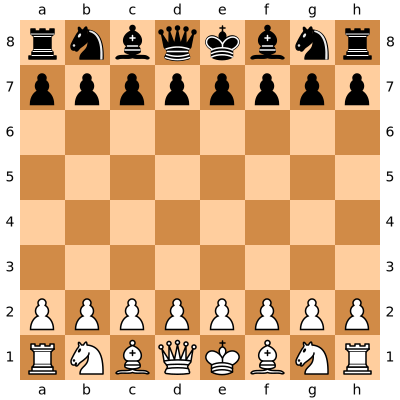

In [4]:
chess.Board(ChessEnv().reset().board.fen())

In [5]:
root_fen = ChessEnv().reset().board.fen()
player = ChessPlayer(cfg, pipes=ev.cur_pipes, play_config=cfg.eval.play_config)

# build tree of depth 6, branching factor 3 from starting position
n = ChessTreeNode.build_tree(
    root_fen,
    player,
    B=3,
    depth=6
)

AI tried illegal move e5e4
AI tried illegal move e8e5
AI tried illegal move f7f6
AI tried illegal move d7d5
AI tried illegal move f7f6
AI tried illegal move e5f4
AI tried illegal move d7d6
AI tried illegal move d7d5
AI tried illegal move f7f6
AI tried illegal move d7d6
AI tried illegal move d7d6
AI tried illegal move e8e5
AI tried illegal move d7d5
AI tried illegal move g7f6
AI tried illegal move b8c6
AI tried illegal move f6d5
AI tried illegal move f6e4
AI tried illegal move f6g4
AI tried illegal move f6g4
AI tried illegal move f6d5
AI tried illegal move f6g8
AI tried illegal move f7f6
AI tried illegal move c6c5
AI tried illegal move d7d5
AI tried illegal move f7f6
AI tried illegal move d7d5
AI tried illegal move f7f5
AI tried illegal move e8e5
AI tried illegal move f7f6
AI tried illegal move d7d6
AI tried illegal move e8e5
AI tried illegal move c6e5
AI tried illegal move c6c5
AI tried illegal move f7f6
AI tried illegal move d7d5
AI tried illegal move d7d6
AI tried illegal move d7d5
A

AI tried illegal move e7e6
AI tried illegal move c7c6
AI tried illegal move g8f6
AI tried illegal move e7e6
AI tried illegal move c8e6
AI tried illegal move e7e5
AI tried illegal move g8f6
AI tried illegal move f7f5
AI tried illegal move g8f6
AI tried illegal move e7e6
AI tried illegal move c8f5
AI tried illegal move e7e6
AI tried illegal move e7e6
AI tried illegal move c8e6
AI tried illegal move e8f7
AI tried illegal move d5e4
AI tried illegal move d5d4
AI tried illegal move e8h5
AI tried illegal move e7e6
AI tried illegal move c7c6
AI tried illegal move b8c6
AI tried illegal move g8f6
AI tried illegal move e7e6
AI tried illegal move c8e6
AI tried illegal move e7e5
AI tried illegal move g8f6
AI tried illegal move f7f5
AI tried illegal move d5e4
AI tried illegal move g8f6
AI tried illegal move d5d4
AI tried illegal move e7e5
AI tried illegal move e7e6


In [6]:
# tree (incomplete) of depth 6, branching factor 3
print(n.pprint())

''
	'c2c4, 0.9952'
		'd7d5, 0.9885'
			'g1f3, 0.4861'
				'f7f6, 0.2690'
					'c4d5, 0.6672'
					'd2d4, 0.1988'
					'e2e3, 0.0436'
			'c4d5, 0.2972'
				'b8c6, 0.2954'
					'd5c6, 0.6690'
					'e2e4, 0.2194'
					'b1c3, 0.0286'
				'f7f6, 0.0296'
					'e2e4, 0.7326'
					'b1c3, 0.0753'
					'g1f3, 0.0700'
						'b8a6, 0.0651'
			'e2e3, 0.1169'
				'f7f6, 0.2032'
					'c4d5, 0.7943'
					'd2d4, 0.1213'
					'g1f3, 0.0370'
				'b8c6, 0.1234'
					'c4d5, 0.6267'
					'd2d4, 0.2002'
					'g1f3, 0.1054'
		'f7f5, 0.0066'
			'g2g3, 0.8202'
				'b8c6, 0.9304'
					'd2d4, 0.7581'
						'd7d5, 0.1740'
						'd7d6, 0.1320'
					'f1g2, 0.1822'
						'd7d5, 0.5329'
						'b7b6, 0.0275'
					'b1c3, 0.0397'
						'd7d5, 0.4104'
						'b7b6, 0.0549'
				'd7d5, 0.0448'
					'c4d5, 0.7466'
						'b8c6, 0.6525'
					'f1g2, 0.1422'
						'b8c6, 0.4439'
					'd2d4, 0.0462'
						'b8c6, 0.0974'
			'd2d4, 0.0698'
				'b8c6, 0.8231'
					'g1f3, 0.5359'
						'd7d6, 0.4355'
						'e7e6, 0.0757'
					'g2g3, 0

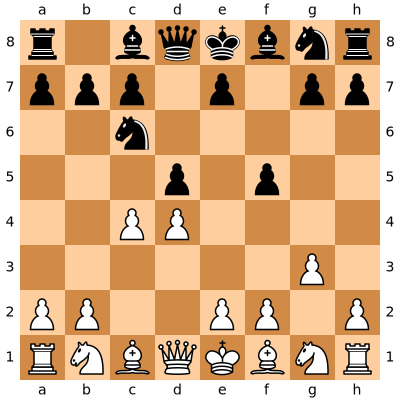

('r1bqkbnr/ppp1p1pp/2n5/3p1p2/2PP4/6P1/PP2PP1P/RNBQKBNR w KQkq - 0 4',
 0.000661273946103626)

In [7]:
# most likely state after 6 moves
n.most_likely_state(6)

2021-04-12 04:26:40,432@matplotlib.font_manager DEBUG # findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2021-04-12 04:26:40,437@matplotlib.font_manager DEBUG # findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
2021-04-12 04:26:40,438@matplotlib.font_manager DEBUG # findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
2021-04-12 04:26:40,439@matplotlib.font_manager DEBUG # findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335
2021-04-12 04:26:40,441@matplotlib.font_manager DEBUG # findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
2021-04-12 04:26:40,442@matplotlib.font_manager DEBUG # findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05
2021-04-12 04:26:40,443@matplotlib.font_manager DEBUG # findfont: score(<Font 'cmr10' (cmr10.ttf)

2021-04-12 04:26:40,509@matplotlib.font_manager DEBUG # findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
2021-04-12 04:26:40,510@matplotlib.font_manager DEBUG # findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
2021-04-12 04:26:40,512@matplotlib.font_manager DEBUG # findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal 200 normal>) = 0.24
2021-04-12 04:26:40,513@matplotlib.font_manager DEBUG # findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-BI.ttf) italic normal 700 normal>) = 11.335
2021-04-12 04:26:40,514@matplotlib.font_manager DEBUG # findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996
2021-04-12 04:26:40,515@matplotlib.font_manager DEBUG # findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
2021-04-12 04:26:40,516@matplotlib.font_manager DEBUG # findf

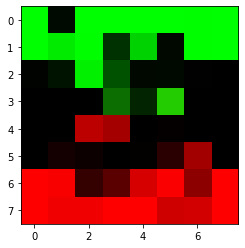

array([[[0.00000000e+00, 3.27250476e-03, 0.00000000e+00],
        [0.00000000e+00, 1.40074986e-04, 0.00000000e+00],
        [0.00000000e+00, 3.27250476e-03, 0.00000000e+00],
        [0.00000000e+00, 3.27250476e-03, 0.00000000e+00],
        [0.00000000e+00, 3.27250476e-03, 0.00000000e+00],
        [0.00000000e+00, 3.27250476e-03, 0.00000000e+00],
        [0.00000000e+00, 3.25676723e-03, 0.00000000e+00],
        [0.00000000e+00, 3.27250476e-03, 0.00000000e+00]],

       [[0.00000000e+00, 3.27250476e-03, 0.00000000e+00],
        [0.00000000e+00, 3.02251486e-03, 0.00000000e+00],
        [0.00000000e+00, 3.26691608e-03, 0.00000000e+00],
        [0.00000000e+00, 6.35292673e-04, 0.00000000e+00],
        [0.00000000e+00, 2.68257320e-03, 0.00000000e+00],
        [0.00000000e+00, 1.07914159e-04, 0.00000000e+00],
        [0.00000000e+00, 3.25047060e-03, 0.00000000e+00],
        [0.00000000e+00, 3.27250476e-03, 0.00000000e+00]],

       [[0.00000000e+00, 4.06075701e-05, 0.00000000e+00],
        [0

In [8]:
# probability map of occupying each cell (R: white, G: black)
n.heatmap_for_states(n.bfs_depth_D(6))